In [1]:
import os

# Create directory for raw QuickDraw data if not existing
os.makedirs("quickdraw_raw", exist_ok=True)

# Vocabulary list - target words for drawing recognition
classes = ['apple', 'sun', 'clock', 'basketball', 'donut', 'tree', 'fish', 'cat', 'dog', 'house']

print("Starting download of QuickDraw dataset for target vocabulary...")

# Download .ndjson files for each class
for cls in classes:
    url = f"https://storage.googleapis.com/quickdraw_dataset/full/raw/{cls}.ndjson"
    output = f"quickdraw_raw/{cls}.ndjson"
    try:
        # Download the dataset file
        !wget -q --show-progress -O $output $url
        print(f"Successfully downloaded data for '{cls}'.")
    except Exception as e:
        print(f"Failed to download data for '{cls}': {str(e)}")

print("All dataset downloads complete. Ready for data preprocessing.")


Starting download of QuickDraw dataset for target vocabulary...
quickdraw_raw/apple 100%[===================>] 375.13M  7.08MB/s    in 6.5s    
Successfully downloaded data for 'apple'.
quickdraw_raw/sun.n 100%[===================>] 408.09M   114MB/s    in 3.6s    
Successfully downloaded data for 'sun'.
quickdraw_raw/clock 100%[===================>] 292.71M  46.0MB/s    in 7.9s    
Successfully downloaded data for 'clock'.
quickdraw_raw/baske 100%[===================>] 476.61M   121MB/s    in 4.1s    
Successfully downloaded data for 'basketball'.
quickdraw_raw/donut 100%[===================>] 390.73M   115MB/s    in 3.4s    
Successfully downloaded data for 'donut'.
quickdraw_raw/tree. 100%[===================>] 548.38M  96.5MB/s    in 5.5s    
Successfully downloaded data for 'tree'.
quickdraw_raw/fish. 100%[===================>] 363.35M   136MB/s    in 2.7s    
Successfully downloaded data for 'fish'.
quickdraw_raw/cat.n 100%[===================>] 496.94M  59.2MB/s    in 6.5s    
S

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
import zipfile

zip_path = '/content/drive/MyDrive/quickdraw_raw.zip'             # path to your zip file
extract_path = 'quickdraw_raw'             # folder to extract to

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete.")


Extraction complete.


In [9]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt

def ndjson_to_images(ndjson_path, output_dir, max_images=1000):
    os.makedirs(output_dir, exist_ok=True)
    with open(ndjson_path, 'r') as f:
        for i, line in enumerate(f):
            if i >= max_images:
                break
            data = json.loads(line)
            strokes = data['drawing']

            plt.figure(figsize=(1.28,1.28))  # 128x128 px size
            plt.axis('off')

            for stroke in strokes:
                x = stroke[0]
                y = stroke[1]
                plt.plot(x, y, 'k-', linewidth=2)

            plt.gca().invert_yaxis()
            plt.savefig(f"{output_dir}/img_{i}.png", bbox_inches='tight', pad_inches=0,dpi=100)
            plt.close()

# Example usage for 'apple' class
ndjson_path = 'quickdraw_raw/apple.ndjson'
output_dir = 'images/apple'
ndjson_to_images(ndjson_path, output_dir, max_images=500)  # You can adjust max_images


In [10]:
for cls in classes:
    print(f"Processing class: {cls}")
    ndjson_path = f'quickdraw_raw/{cls}.ndjson'
    output_dir = f'images/{cls}'
    ndjson_to_images(ndjson_path, output_dir, max_images=500)


Processing class: apple
Processing class: sun
Processing class: clock
Processing class: basketball
Processing class: donut
Processing class: tree
Processing class: fish
Processing class: cat
Processing class: dog
Processing class: house


Total images in dataset: 5000


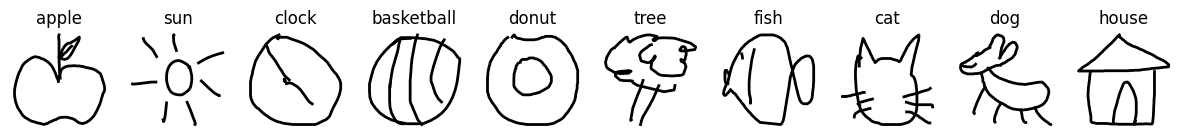

In [11]:
# import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import random

class QuickDrawDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for idx, cls in enumerate(classes):
            cls_folder = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_folder):
                if img_name.endswith('.png'):
                    self.image_paths.append(os.path.join(cls_folder, img_name))
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Instantiate dataset
dataset = QuickDrawDataset(root_dir='images', classes=classes, transform=transform)
print(f"Total images in dataset: {len(dataset)}")

# Visualize one random sample per class
classes_to_show = classes[:]
fig, axs = plt.subplots(1, len(classes_to_show), figsize=(15, 3))

for i, cls in enumerate(classes_to_show):
    cls_indices = [idx for idx, label in enumerate(dataset.labels) if label == i]
    sample_idx = random.choice(cls_indices)
    img, label = dataset[sample_idx]
    axs[i].imshow(img.squeeze(), cmap='gray')
    axs[i].set_title(f"{classes[label]}")
    axs[i].axis('off')

plt.show()


In [12]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Define the transform with resize to 28x28
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize images to 28x28
    transforms.Grayscale(),       # If your images are RGB, convert to grayscale (1 channel)
    transforms.ToTensor(),
    # Optional normalization if you used it during training:
    # transforms.Normalize((0.5,), (0.5,))
])

# Assuming your dataset class accepts a transform argument
# Recreate dataset with the updated transform
dataset = QuickDrawDataset(root_dir='images', classes=classes, transform=transform)

# Create DataLoader for training
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Check the first batch shape
images, labels = next(iter(train_loader))
print(f"Batch image tensor shape: {images.shape}")  # Expected: [batch_size, 1, 28, 28]
print(f"Batch labels tensor shape: {labels.shape}")  # Expected: [batch_size]


Batch image tensor shape: torch.Size([32, 1, 28, 28])
Batch labels tensor shape: torch.Size([32])


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Assuming 'dataset' and 'classes' are already defined and loaded

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 28x28 -> 14x14
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 14x14 -> 7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Split dataset into train/test sets
dataset_size = len(dataset)
indices = list(range(dataset_size))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42, stratify=dataset.labels)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

best_test_acc = 0.0
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        try:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if batch_idx % 50 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")

        except Exception as e:
            print(f"Error during training batch {batch_idx}: {e}")

    train_loss = running_loss / total
    train_acc = correct / total

    test_acc = evaluate(model, test_loader, device)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    # Save checkpoint if test accuracy improves
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best model saved with Test Acc: {best_test_acc:.4f}")

    # Step the scheduler
    scheduler.step()

print("Training complete.")


Training samples: 4000, Testing samples: 1000
Epoch [1/20], Batch [0/125], Loss: 2.2860
Epoch [1/20], Batch [50/125], Loss: 2.2091
Epoch [1/20], Batch [100/125], Loss: 1.2487
Epoch 1/20 - Train Loss: 1.8940, Train Acc: 0.3455, Test Acc: 0.6120
Best model saved with Test Acc: 0.6120
Epoch [2/20], Batch [0/125], Loss: 1.0308
Epoch [2/20], Batch [50/125], Loss: 1.1811
Epoch [2/20], Batch [100/125], Loss: 0.6976
Epoch 2/20 - Train Loss: 0.8661, Train Acc: 0.7163, Test Acc: 0.7170
Best model saved with Test Acc: 0.7170
Epoch [3/20], Batch [0/125], Loss: 0.9557
Epoch [3/20], Batch [50/125], Loss: 0.6440
Epoch [3/20], Batch [100/125], Loss: 0.4110
Epoch 3/20 - Train Loss: 0.6954, Train Acc: 0.7785, Test Acc: 0.7560
Best model saved with Test Acc: 0.7560
Epoch [4/20], Batch [0/125], Loss: 0.6729
Epoch [4/20], Batch [50/125], Loss: 0.6557
Epoch [4/20], Batch [100/125], Loss: 0.5908
Epoch 4/20 - Train Loss: 0.5746, Train Acc: 0.8213, Test Acc: 0.8180
Best model saved with Test Acc: 0.8180
Epoch 

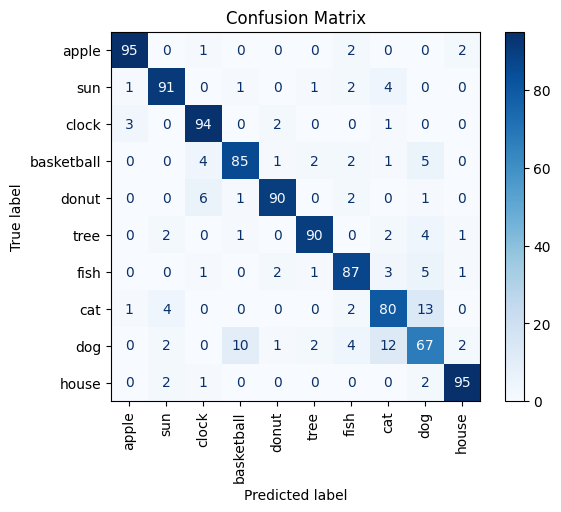

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get all predictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


In [15]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

# Define your transform (same as training)
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def give_feedback(image_path, model, class_names, device):
    model.eval()
    image = Image.open(image_path).convert('L')  # Grayscale for consistency
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)[0]
        confidence, predicted_idx = torch.max(probabilities, 0)

    predicted_class = class_names[predicted_idx.item()]
    confidence_value = confidence.item()

    if confidence_value >= 0.8:
        feedback = f"✅ Great job! That looks like a **{predicted_class}**! (Confidence: {confidence_value:.2f})"
    elif 0.4 <= confidence_value < 0.8:
        feedback = f"🤔 Could it be a **{predicted_class}**? Try refining your drawing. (Confidence: {confidence_value:.2f})"
    else:
        feedback = f"❌ Hmm... I'm not sure. Try again! Hint: a **{predicted_class}** usually has distinct features. (Confidence: {confidence_value:.2f})"

    return predicted_class, confidence_value, feedback



🔍 Testing class: APPLE


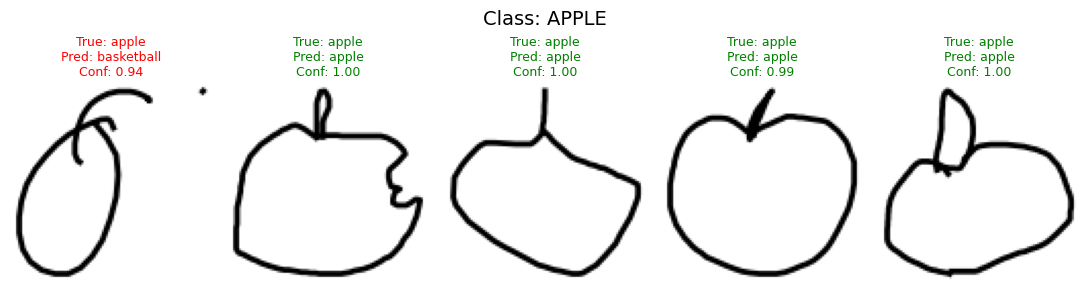


🔍 Testing class: SUN


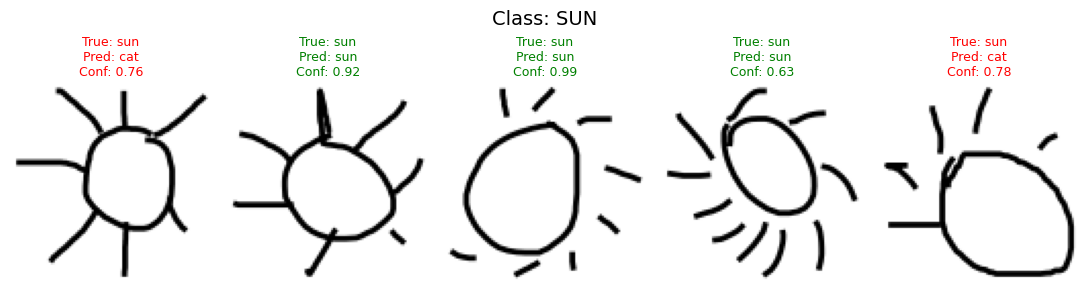


🔍 Testing class: CLOCK


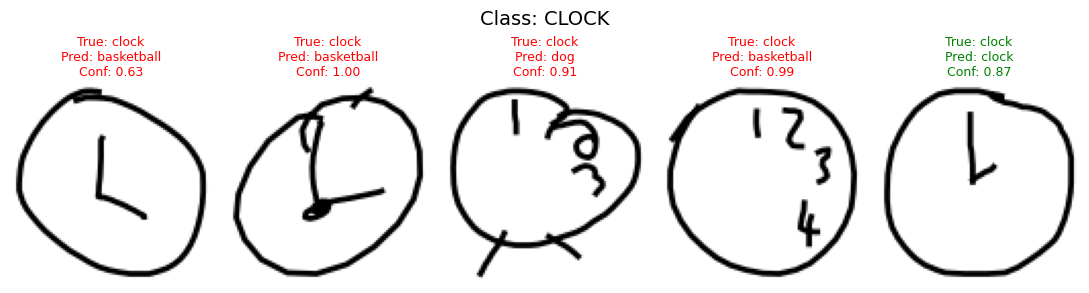


🔍 Testing class: BASKETBALL


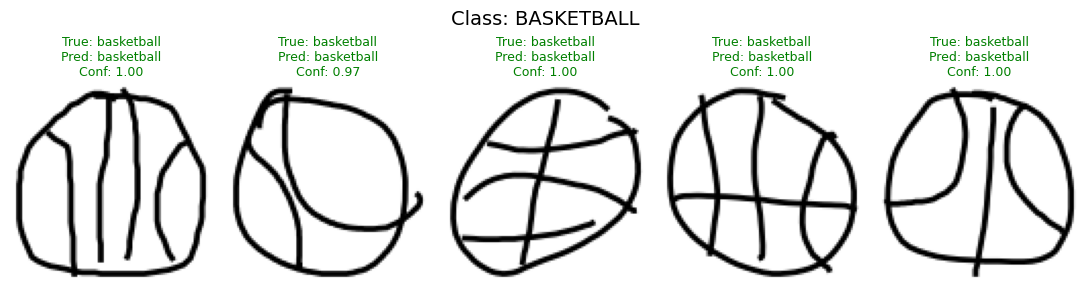


🔍 Testing class: DONUT


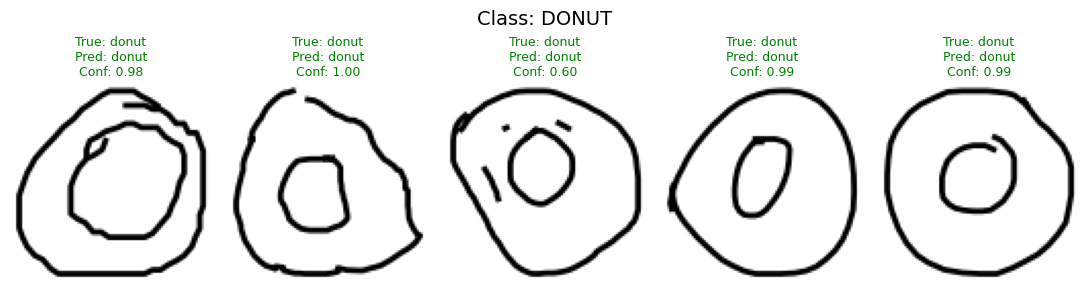


🔍 Testing class: TREE


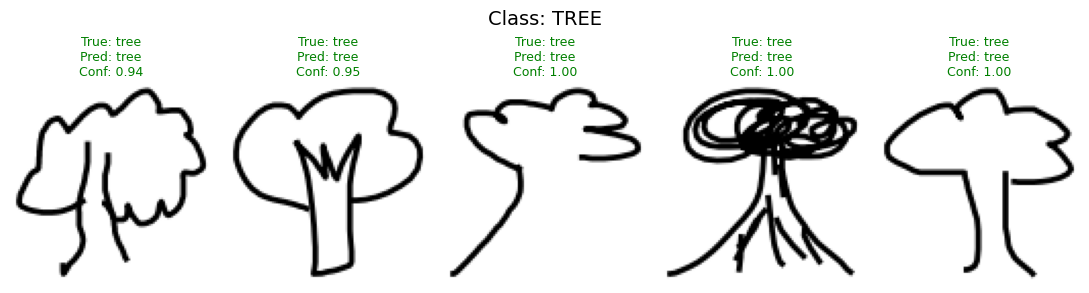


🔍 Testing class: FISH


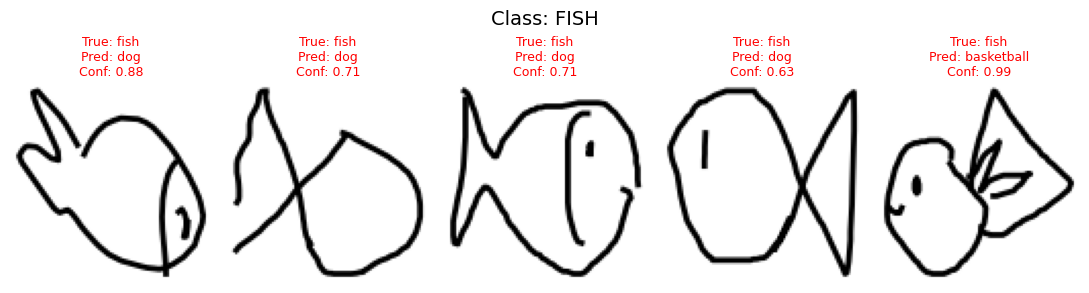


🔍 Testing class: CAT


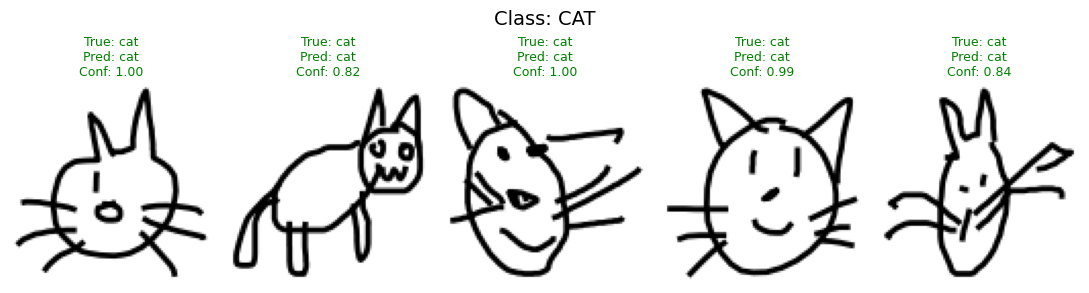


🔍 Testing class: DOG


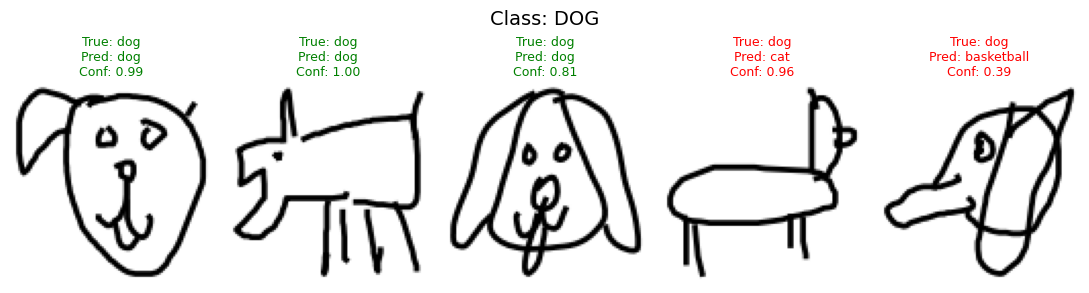


🔍 Testing class: HOUSE


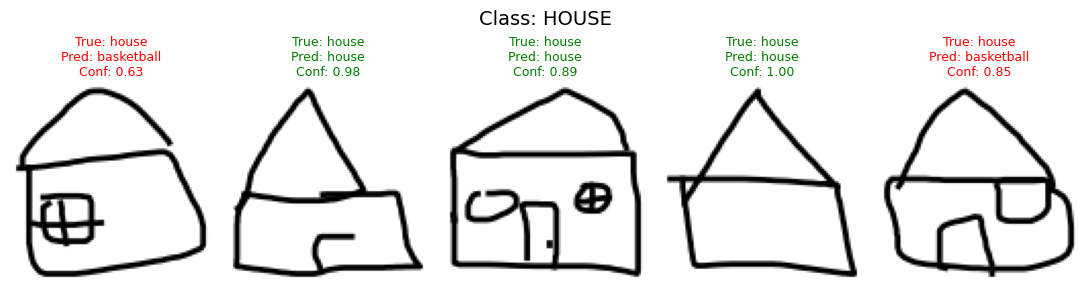


❗ Misclassified Images – Explained Simply:
🖼️ img_0.png — It was a drawing of a **apple**, but the AI thought it's a **basketball** with 94% confidence.
🖼️ img_0.png — It was a drawing of a **sun**, but the AI thought it's a **cat** with 76% confidence.
👉 Likely confused sun rays with whiskers or fur.
🖼️ img_4.png — It was a drawing of a **sun**, but the AI thought it's a **cat** with 78% confidence.
👉 Likely confused sun rays with whiskers or fur.
🖼️ img_0.png — It was a drawing of a **clock**, but the AI thought it's a **basketball** with 63% confidence.
👉 Both are circles with inner lines; unclear clock hands might look like basketball seams.
🖼️ img_1.png — It was a drawing of a **clock**, but the AI thought it's a **basketball** with 100% confidence.
👉 Both are circles with inner lines; unclear clock hands might look like basketball seams.
🖼️ img_2.png — It was a drawing of a **clock**, but the AI thought it's a **dog** with 91% confidence.
🖼️ img_3.png — It was a drawing of a **c

In [16]:
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_images = 5  # number of images per class to test
incorrect_predictions = []

for cls in classes:
    print(f"\n🔍 Testing class: {cls.upper()}")

    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 2.2, 3))
    fig.suptitle(f"Class: {cls.upper()}", fontsize=14)

    for i in range(num_images):
        image_path = f"/content/images/{cls}/img_{i}.png"

        predicted_class, confidence, feedback = give_feedback(image_path, model, classes,device)
        img = Image.open(image_path)
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')

        is_correct = predicted_class == cls
        color = 'green' if is_correct else 'red'

        # Set colored title
        axs[i].set_title(
            f"True: {cls}\nPred: {predicted_class}\nConf: {confidence:.2f}",
            fontsize=9,
            color=color
        )

        # Collect incorrect predictions
        if not is_correct:
            incorrect_predictions.append({
                "actual": cls,
                "predicted": predicted_class,
                "image_path": image_path,
                "confidence": confidence
            })

    plt.tight_layout()
    plt.subplots_adjust(top=0.75)
    plt.show()

# Print easy-to-understand error summary
if incorrect_predictions:
    print("\n❗ Misclassified Images – Explained Simply:")
    for err in incorrect_predictions:
        actual, predicted, path, conf = err["actual"], err["predicted"], err["image_path"], err["confidence"]
        print(f"🖼️ {os.path.basename(path)} — It was a drawing of a **{actual}**, but the AI thought it's a **{predicted}** with {conf:.0%} confidence.")
        if actual == "sun" and predicted == "cat":
            print("👉 Likely confused sun rays with whiskers or fur.")
        elif actual == "clock" and predicted == "basketball":
            print("👉 Both are circles with inner lines; unclear clock hands might look like basketball seams.")
else:
    print("\n🎉 Great news! All predictions were correct.")
